In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import torch
import os
import random

%matplotlib inline
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [121]:
def train_model(model, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=500):
    X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)
    max_length_train = X_train_padded.size(1)
    X_train_padded = X_train_padded.view(-1, max_length_train, 1)
    X_test_padded = torch.nn.utils.rnn.pad_sequence(X_test, batch_first=True)
    max_length_test = X_test_padded.size(1)
    X_test_padded = X_test_padded.view(-1, max_length_test, 1)
    train_accuracy = []
    test_accuracy = []
    train_batch_size = len(X_train_lengths)
    for i in range(epochs):
        params = list(model.named_parameters())
        model.zero_grad()
        hidden = model.init_hidden(train_batch_size).float()
        output = model(X_train_padded, hidden, X_train_lengths)
        print(output, Y_train)
        loss = F.cross_entropy(output, Y_train)
        loss.backward()
        optimizer.step()
        for param_name, param in params:
            print(param_name, np.linalg.norm(param.grad.to("cpu").numpy()))
        optimizer.zero_grad()
        tr_accuracy = test_model(model, X_train, X_train_lengths, Y_train)
        train_accuracy.append(tr_accuracy)
        tst_accuracy = test_model(model, X_test, X_test_lengths, Y_test)
        test_accuracy.append(tst_accuracy)
    
    return model.eval(), train_accuracy, test_accuracy

In [140]:
def test_model(model, X_samp, X_samp_lengths, Y_samp):
    batch_size = len(X_samp_lengths)
    hidden = model.init_hidden(batch_size).float()
    X_samp_padded = torch.nn.utils.rnn.pad_sequence(X_samp, batch_first=True)
    max_length_samp = X_samp_padded.size(1)
    X_samp_padded = X_samp_padded.view(-1, max_length_samp, 1)
    output_test = model(X_samp_padded, hidden, X_samp_lengths)
    total = 0
    correct = 0
    for i, out_t in enumerate(output_test):
        if int(torch.argmax(out_t)) - int(Y_samp[i]) == 0:
            correct = correct + 1
        total = total + 1

    return (correct/total)

In [141]:
class ModelOne(nn.Module):
    
    def __init__(self):
        super(ModelOne, self).__init__()
        self.rnn = nn.RNN(1, 128, 4, nonlinearity="relu", dropout=0.25, batch_first=True)
        self.dense = nn.Linear(128, 18)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(4, batch_size, 128).to(device)

        return hidden
    
    def forward(self, x, hidden, x_lengths):
        batch_size = x.size(0)
        max_sequence_size = x.size(1)
        # hidden = self.init_hidden(batch_size).float()
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
        out, hidden = self.rnn(x, hidden)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = out.contiguous()
        out = out.view(-1, 128)
        out = self.dense(out)
        out = out.view(batch_size, max_sequence_size, 18)
        
        indexes = torch.tensor(x_lengths) - 1
        out = out[torch.arange(batch_size), indexes, :]
        
        return F.softmax(out, dim=1)

In [142]:
model_one = ModelOne().to(device)

In [3]:
t = np.arange(0, 10, 0.1)

In [5]:
y = np.sin(t)

In [125]:
X = []
Y = []
freq = list(range(1, 19))

for i in freq:
    for n in range(100):
        limit = random.randint(10, 20)
        t = np.arange(0, limit, 0.1)
        x = np.sin(i * t)
        X.append(x)
        Y.append(i-1)

In [126]:
data = {}
for i in Y:
    if i not in data:
        data[i] = [X[i]]
    else:
        data[i].append(X[i])


In [127]:
X_train = []
Y_train = []
X_test = []
Y_test = []
for i , sequences in data.items():
    for training_seq in sequences[:int(0.8 * len(sequences))]:
        X_train.append(training_seq)
        Y_train.append(i)
    for testing_seq in sequences[int(0.8 * len(sequences)):]:
        X_test.append(testing_seq)
        Y_test.append(i)

train_set = list(zip(X_train, Y_train))
train_set = sorted(train_set, key=lambda t: len(t[0]), reverse=True)
test_set = list(zip(X_test, Y_test))
test_set = sorted(test_set, key=lambda t: len(t[0]), reverse=True)

In [128]:
X_train = []
X_train_lengths = []
Y_train = []
X_test = []
X_test_lengths = []
Y_test = []
for x, y in train_set:
    X_train.append(torch.tensor(x).float().to(device))
    X_train_lengths.append(len(x))
    Y_train.append(torch.tensor(y))

Y_train = torch.tensor(Y_train).to(device)

for x, y in test_set:
    X_test.append(torch.tensor(x).float().to(device))
    X_test_lengths.append(len(x))
    Y_test.append(torch.tensor(y))

Y_test = torch.tensor(Y_test).to(device)

In [129]:
X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)

In [130]:
X_train_padded.size()

torch.Size([1440, 200])

In [131]:
train_batch_size = X_train_padded.size(0)
hidden = model_one.init_hidden(train_batch_size).float()

In [143]:
optimizer = optim.Adam(model_one.parameters(), lr=0.001)
model_one, train_accuracy, test_accuracy = train_model(model_one, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=3)

tensor([[0.0549, 0.0550, 0.0524,  ..., 0.0561, 0.0618, 0.0528],
        [0.0540, 0.0559, 0.0514,  ..., 0.0560, 0.0614, 0.0534],
        [0.0536, 0.0550, 0.0530,  ..., 0.0567, 0.0616, 0.0535],
        ...,
        [0.0555, 0.0542, 0.0519,  ..., 0.0567, 0.0616, 0.0525],
        [0.0542, 0.0539, 0.0527,  ..., 0.0553, 0.0608, 0.0530],
        [0.0536, 0.0538, 0.0532,  ..., 0.0553, 0.0618, 0.0523]],
       grad_fn=<SoftmaxBackward>) tensor([5, 5, 5,  ..., 0, 0, 0])
rnn.weight_ih_l0 0.00027008992
rnn.weight_hh_l0 0.00018210741
rnn.bias_ih_l0 0.00019500265
rnn.bias_hh_l0 0.00019500282
rnn.weight_ih_l1 0.0003402628
rnn.weight_hh_l1 0.00024486208
rnn.bias_ih_l1 0.00023516035
rnn.bias_hh_l1 0.00023516073
rnn.weight_ih_l2 0.000490607
rnn.weight_hh_l2 0.00027784036
rnn.bias_ih_l2 0.00031027116
rnn.bias_hh_l2 0.0003102711
rnn.weight_ih_l3 0.0005049053
rnn.weight_hh_l3 0.00025868832
rnn.bias_ih_l3 0.00029369406
rnn.bias_hh_l3 0.00029369476
dense.weight 0.00045852564
dense.bias 6.585411e-05
tensor([[

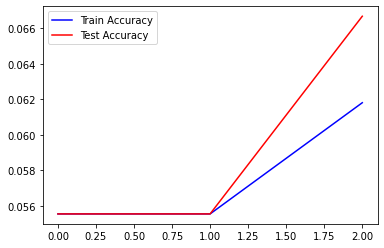

In [144]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()